# Underground E-field

## Import Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker, cm, colors
plt.rcParams["figure.figsize"] = (8,6)

## Function definitions

### FFT & IFFT
Centered FFT and IFFT

In [2]:
def centered_fft(x, Fs):
    N2, N1=np.shape(x)
    #this part of the code generates that frequency axis
    if N1 % 2==0:
        k = np.arange(-N1/2, N1/2) # N even
    else:
        k = np.arange(-(N1-1)/2,(N1-1)/2+1) # N odd

    T = N1/Fs
    freq = k/T #  %the frequency axis

    #takes the fft of the signal, and adjusts the amplitude accordingly
    X = np.fft.fft(x)#/N1 # normalize the data
    X = np.fft.fftshift(X,1) #shifts the fft data so that it is centered
    return X, freq


In [3]:
def centered_ifft(x, f):
    #función que calcula la antitransformada de fourier de un vector
    #transformado, centrado en frec 0, con el espectro completo.
    #x -> vector de salida del centeredFFT, espectro completo, centrado en 0, y
    #     de magnitudes divididas entre 2.
    #f -> vector de frecuencia de salida del centeredFFT
    N = len(x)
    dt = 1 / (2*f[-1])               #diferencial de tiempo
    t=np.arange(0, (N)*dt, dt)     #Vector de tiempo


    X = np.fft.ifftshift(x,0)     #"descentralizar" el vector a antitransformar
    X = np.fft.ifft(X)#N          # normalizar la data a valores reales    
    return X, t

### Heidler function
Chanel base current according to Heidler's function.

In [4]:
def IdobleH2(t, Io1, Io2, tf1, ts1, tf2, ts2, n1, n2):
    # t -> es el vector de tiempo sobre el cual se quiere calcular
    # Io -> es el valor de la corriente pico
    # nu -> es el factor de correlación de la corriente pico
    # tf -> constante de tiempo de frente
    # ts -> constante de tiempo de semiamplitud

    nu_1 = np.exp(-1*((tf1/ts1)*((n1*ts1/tf1)**(1/n1))))
    nu_2 = np.exp(-1*((tf2/ts2)*((n2*ts2/tf2)**(1/n2))))

    I1 = (Io1/nu_1)*((t/tf1)**n1)*np.exp(-t/ts1)/(((t/tf1)**n1)+1) 
    I2 = (Io2/nu_2)*((t/tf2)**n2)*np.exp(-t/ts2)/(((t/tf2)**n2)+1)
    I = I1+I2
    return I

### Current propagation along the channel
Matrix of transient current at each dipole along the channel, following the Modified Transmission Line Exponential model of propagtion of the channel base current.

In [5]:
def MTLE(Ib,t,z_i,vf,alfa):
    # Ib -> Channel base transient current
    # t -> time vector
    # z_i -> ith-dipole height
    # vf -> current front propagation velocity
    # alfa -> Attenuation constant
    dim = len(t)
    t_delay = np.ones(dim)*np.abs(z_i)/vf
    aten = np.abs(z_i)/alfa
    Izt = (((t-t_delay)>0)*(np.exp(-aten)*Ib(t-t_delay))) + (((t-t_delay)==0)*(0.5)*(np.exp(-aten)*Ib(t-t_delay)))
    return Izt

### Azimuthal magnetic field
Magnetic field raidated by the lightning channel at ground level. In the azimuthal direction of a cilindrical coordinate system. Following Bannister expression.

In [6]:
def hph_bannister(Izw,w,dh,R,D):
    #% Izw --> Matriz de corrientes para cada dh
    #% w   --> Vector de frecuenccias
    #% dh  --> largo del dipolo
    #% R   --> Distancia neta al punto de medici�n
    #% D   --> Distancia horizontal al punto de medici�n

    e0 = 8.8541878176*1e-12   #Permitividad el�ctrica del vac�o
    u0 = 4*np.pi*1e-7         #Permeabilidad magn�tica del vac�o
    c = 1/np.sqrt(e0*u0)       #Velocidad de la luz
    
    Hlist = []
    for idx, r_i in enumerate(R):
        e1 = D / r_i**3
        e2 = D /(c*r_i**2)*(1j*w)
        H_aux = (1/(4*np.pi)) * (Izw[idx,:]*np.exp(-1j*w*(r_i / c))*( e1 + e2 ))
        Hlist.append(H_aux)
    Harr = np.array(Hlist)
    H = np.trapz(y=Harr,dx=dh, axis=0)
    
    if np.isnan(H[0]):
        H[0] = 0.0
    return H

### Horizontal Electric field at ground level

In [7]:
def er_cooray_rub(H, w, er, sig):
    # H --> Campo magnetico azimutal
    # w -> Vector de frecuencias
    # er -> permitividad relativa del suelo
    # sig -> conductividad del suelo
    e0 = 8.8541878176*1e-12   #Permitividad eléctrica del vacío
    u0 = 4*np.pi*1e-7          #Permeabilidad magnética del vacío
    c = 1/np.sqrt(e0*u0)       #Velocidad de la luz
    E = -H*((c*u0) / (np.sqrt(er+(sig/(1j*w*e0)))))

    pos = np.argwhere(np.isnan(E))
    E[pos] = 0
    return E

### Horizontal Electric field underground

In [8]:
def er_cooray_BS(d, Er_0, w, er, sig):
    # Er_0 --> Campo Electrico horizontal en la superficie del suelo
    # w -> Vector de frecuencias
    # er -> permitividad relativa del suelo
    # sig -> conductividad del suelo
    e0 = 8.85418781761*1e-12   #Permitividad eléctrica del vacío
    u0 = 4*np.pi*1e-7          #Permeabilidad magnética del vacío
    c = 1/np.sqrt(e0*u0)       #Velocidad de la luz

    g1 = np.sqrt(w*u0*(1j*sig - w*er*e0))
    E = Er_0*(np.exp(-g1*d))
    
    pos = np.argwhere(np.isnan(E))
    E[pos] = 0
    return E



## Input parameters
### Time parameters

In [9]:
t_inic = 0
t_fina = 1250*1e-6
nt = 8334
t, dt = np.linspace(t_inic, t_fina, nt, retstep= True)

In [10]:
print('El intervalo de tiempo dt es: {0:2f} us'.format(dt*1e6))

El intervalo de tiempo dt es: 0.150006 us


### Channel Base current
Choose which of the three types of channel base current you are going to use.

- 'nFS': for Negative First Stroke
- 'SS' : for the subsequent stroke
- 'P': for the third stroke of Petrache et al. 2009.

In [11]:
cb_current = 'nFS' #nFS: First stroke, #SS: subsequent stroke , #P: Petrache2005
if cb_current == 'nFS':
    
    Io1 = 28.0e3
    n1 = 2.0
    tf1 = 1.8e-6
    ts1 = 95e-6
    Io2 = 0.0
    n2 = 2.0
    tf2 = 2e-6
    ts2 = 230e-6
elif cb_current == 'SS':
    Io1 = 10.7e3
    n1 = 2.0
    tf1 = 0.25e-6
    ts1 = 2.5e-6
    Io2 = 6.5e3
    n2 = 2.0
    tf2 = 2.0e-6
    ts2 = 230e-6
elif cb_current == 'P':
    Io1 = 8.5*1e3
    n1 = 2.0
    tf1 = 0.12*1e-6
    ts1 = 14e-6
    Io2 = 3.2*1e3
    n2 = 2.0
    tf2 = 14*1e-6
    ts2 = 95*1e-6

### Current propagation model

In [12]:
h_final = 6000       #Altura del canal [m]
nz = 601             #Diferencial de altura para la integral [m]
z, dh = np.linspace(-h_final, h_final, nz, retstep= True)
v = 1.3*1e8 #Velocidad de propagacion del frente de onda
alfa = 2000          #constante atenuaci�n

In [13]:
print('La altura de cada dipolo es: {} m'.format(dh))

La altura de cada dipolo es: 20.0 m


### Ground

In [14]:
er = 10.0                #Permitividad relativa del suelo
sig = 1*1e-2           #Conductividad del suelo
h = -5.0 #m profundidad del punto de observacion del campo
D = 50.0 #m distancia de la base del canal del punto de observacion

## Calculos
### Channel base current

In [15]:
Ibase = IdobleH2(t,Io1,Io2,tf1,ts1,tf2,ts2,n1,n2)

<function matplotlib.pyplot.show(*args, **kw)>

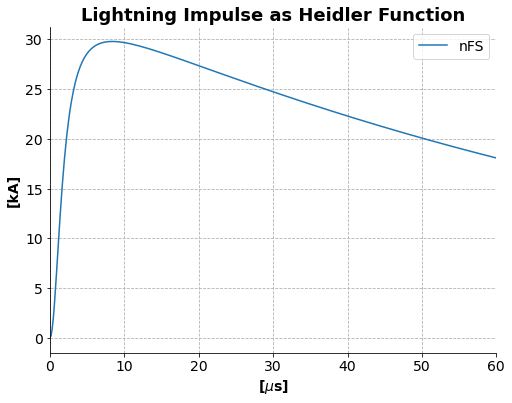

In [16]:
fig, ax = plt.subplots()
ax.plot(t*1e6, Ibase*1e-3, label = cb_current)
ax.set_xlim([0,60.0])
ax.set_ylabel('[kA]',fontsize=14, weight='semibold')
ax.set_xlabel(r'[$\mu$s]',fontsize=14, weight='semibold')
ax.set_title('Lightning Impulse as Heidler Function',fontsize=18, weight='semibold')
ax.grid(ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=14,loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show

### Current propagation along the channel

In [17]:
Izt = []
Ib = lambda x: IdobleH2(x,Io1,Io2,tf1,ts1,tf2,ts2,n1,n2)
for z_i in z:
    Izt.append(MTLE(Ib, t, z_i, v, alfa))
print('La dimension de la matriz de corrientes es:')
np.shape(Izt)

La dimension de la matriz de corrientes es:


(601, 8334)

<function matplotlib.pyplot.show(*args, **kw)>

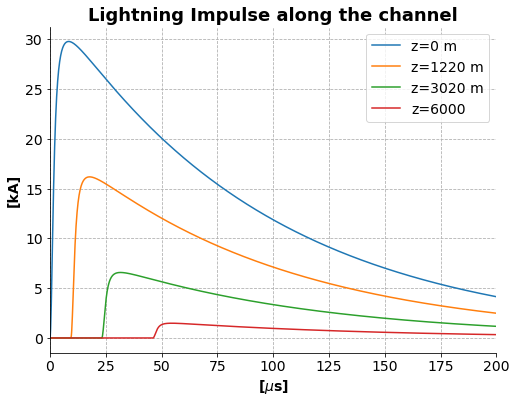

In [18]:
dim_z = len(Izt)
fig, ax = plt.subplots()
ax.plot(t*1e6, Izt[round(dim_z/2)]*1e-3, label = "z={:.0f} m".format(z[round(dim_z/2)]))
ax.plot(t*1e6, Izt[round(0.6*dim_z)]*1e-3, label = "z={:.0f} m".format(z[round(0.6*dim_z)]))
ax.plot(t*1e6, Izt[round(3*dim_z/4)]*1e-3, label = "z={:.0f} m".format(z[round(3*dim_z/4)]))
ax.plot(t*1e6, Izt[-1]*1e-3, label = "z={:.0f}".format(z[-1]))
ax.set_xlim([0,200.0])
ax.set_ylabel('[kA]',fontsize=14, weight='semibold')
ax.set_xlabel(r'[$\mu$s]',fontsize=14, weight='semibold')
ax.set_title('Lightning Impulse along the channel',fontsize=18, weight='semibold')
ax.grid(ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=14,loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show

In [19]:
x = Izt
Fs = 1/dt
Izw, f = centered_fft(Izt, 1/dt)
w=(f*2*np.pi)

<function matplotlib.pyplot.show(*args, **kw)>

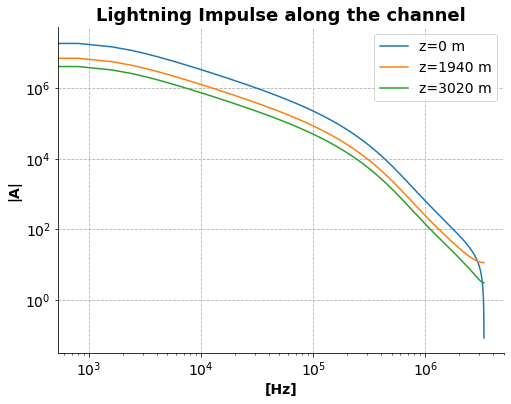

In [20]:
fig, ax = plt.subplots()
ax.plot(f, np.abs(Izw[round(dim_z/2)]), label = "z={:.0f} m".format(z[round(dim_z/2)]))
ax.plot(f, np.abs(Izw[round(0.66*dim_z)]), label = "z={:.0f} m".format(z[round(0.66*dim_z)]))
ax.plot(f, np.abs(Izw[round(0.75*dim_z)]), label = "z={:.0f} m".format(z[round(0.75*dim_z)]))
ax.set_ylabel('|A|',fontsize=14, weight='semibold')
ax.set_xlabel(r'[Hz]',fontsize=14, weight='semibold')
ax.set_title('Lightning Impulse along the channel',fontsize=18, weight='semibold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=14,loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show

### Magnetic Field at ground level

In [21]:
R = np.sqrt((z-h)**2.0 + D**2.0)      #Distancia neta entre un punto del canal y el punto en h donde interesa el campo
R_suelo = np.sqrt(z**2.0 + D**2.0)
Hfield = hph_bannister(Izw,w,dh,R_suelo,D)
Ht, tr = centered_ifft(Hfield, f)
Ht=(Ht-Ht[0]).real
np.isnan(Ht).any()

False

<function matplotlib.pyplot.show(*args, **kw)>

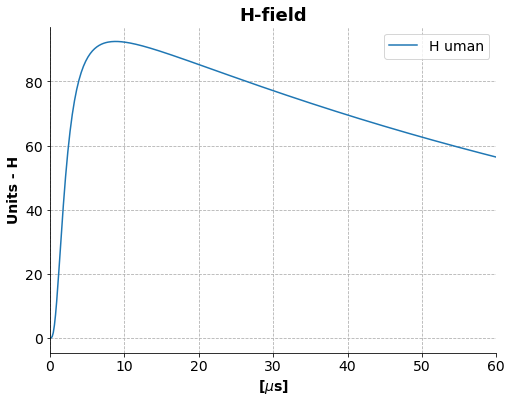

In [22]:
fig, ax = plt.subplots()
ax.plot(tr*1e6, Ht, label = "H uman")
ax.set_xlim([0,60.0])
ax.set_ylabel('Units - H',fontsize=14, weight='semibold')
ax.set_xlabel(r'[$\mu$s]',fontsize=14, weight='semibold')
ax.set_title('H-field',fontsize=18, weight='semibold')
ax.grid(ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=14,loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show

### Electric field at ground surface

In [23]:
Efield = er_cooray_rub(Hfield, w, er, sig)
Et, te = centered_ifft(Efield, f)
Et=(Et-Et[0]).real

/home/diazlg/programas/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/diazlg/programas/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


<function matplotlib.pyplot.show(*args, **kw)>

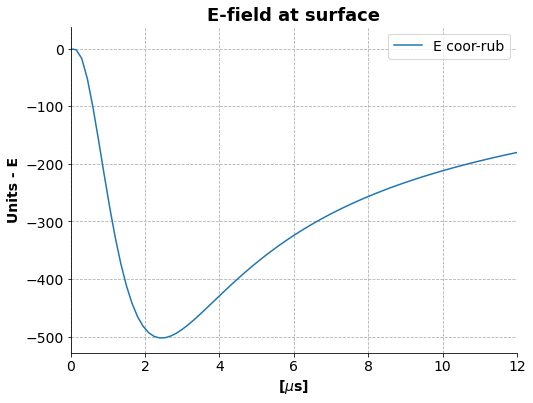

In [24]:
fig, ax = plt.subplots()
ax.plot(tr*1e6, Et, label = "E coor-rub")
ax.set_xlim([0,12.0])
ax.set_ylabel('Units - E',fontsize=14, weight='semibold')
ax.set_xlabel(r'[$\mu$s]',fontsize=14, weight='semibold')
ax.set_title('E-field at surface',fontsize=18, weight='semibold')
ax.grid(ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=14,loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show

### Underground Electric field

In [25]:
Eug = er_cooray_BS(abs(h), Efield, w, er, sig)
Eug_t, te_ug = centered_ifft(Eug, f)
Eug_t = Eug_t-Eug_t[0]

<function matplotlib.pyplot.show(*args, **kw)>

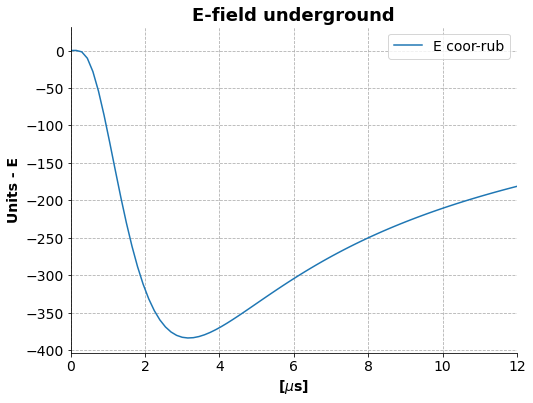

In [26]:
fig, ax = plt.subplots()
ax.plot(te_ug*1e6, np.real(Eug_t), label = "E coor-rub")
ax.set_xlim([0,12.0])
ax.set_ylabel('Units - E',fontsize=14, weight='semibold')
ax.set_xlabel(r'[$\mu$s]',fontsize=14, weight='semibold')
ax.set_title('E-field underground',fontsize=18, weight='semibold')
ax.grid(ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=14,loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show